In [ ]:
#|default_exp core

# Gaspard's source

## Setup

In [ ]:
#| export
import inspect, typing, mimetypes, base64, json, ast, io, os, time, proto
import filetype as ft
import google.generativeai as genai
from google.generativeai.types.generation_types import GenerateContentResponse, GenerationConfig
from google.generativeai.protos import FunctionCall, Content, FunctionResponse, FunctionDeclaration
from google.generativeai.protos import GenerateContentResponse as GCR
from google.generativeai import protos

import toolslm
from toolslm.funccall import *

from fastcore.meta import delegates
from fastcore.utils import *

from collections import abc

from proto.marshal.collections.maps import MapComposite
from proto.marshal.collections.repeated import RepeatedComposite

In [ ]:
#| hide
from nbdev import show_doc

try: from IPython import display
except: display=None

In [ ]:
#| export
UsageMetadata = GCR.UsageMetadata
empty = inspect.Parameter.empty

In [ ]:
#| exports
models = 'gemini-1.5-pro-exp-0827', 'gemini-1.5-flash-exp-0827','gemini-1.5-pro','gemini-1.5-flash'

These are the latest version of Gemini models available at the time of writing.

In [ ]:
model = models[-1]

We'll use gemini-1.5-flash for the examples since it's faster and cheaper.

## Gemini SDK

Follow the [instructions](https://aistudio.google.com/app/apikey) to generate an API key, and set it as an evironment variable.

In [ ]:
genai.configure(api_key=os.environ["GEMINI_API_KEY"])

In [ ]:
cli = genai.GenerativeModel(model)

In [ ]:
r = cli.generate_content("Hi, I'm Faisal!")
r

response:
GenerateContentResponse(
    done=True,
    iterator=None,
    result=protos.GenerateContentResponse({
      "candidates": [
        {
          "content": {
            "parts": [
              {
                "text": "Hi Faisal! It's nice to meet you. What can I do for you today? \n"
              }
            ],
            "role": "model"
          },
          "finish_reason": "STOP",
          "index": 0,
          "safety_ratings": [
            {
              "category": "HARM_CATEGORY_SEXUALLY_EXPLICIT",
              "probability": "NEGLIGIBLE"
            },
            {
              "category": "HARM_CATEGORY_HATE_SPEECH",
              "probability": "NEGLIGIBLE"
            },
            {
              "category": "HARM_CATEGORY_HARASSMENT",
              "probability": "NEGLIGIBLE"
            },
            {
              "category": "HARM_CATEGORY_DANGEROUS_CONTENT",
              "probability": "NEGLIGIBLE"
            }
          ]
        }
      

## Formatting output

In [ ]:
#| exports
def find_block(r:abc.Mapping, # The message to look in
              ):
    "Find the content in `r`."
    m = nested_idx(r, 'candidates', 0)
    if not m: return m
    if hasattr(m, 'content'): return m.content 
    else: return m

In [ ]:
find_block(r)

parts {
  text: "Hi Faisal! It\'s nice to meet you. What can I do for you today? \n"
}
role: "model"

In [ ]:
#| exports
def contents(r):
    "Helper to get the contents from response `r`."
    blk = find_block(r)
    if not blk: return r
    if hasattr(blk, 'parts'): return getattr(blk,'parts')[0].text
    return blk

In [ ]:
contents(r)

"Hi Faisal! It's nice to meet you. What can I do for you today? \n"

In [ ]:
#| exports
@patch()
def _repr_markdown_(self:GenerateContentResponse):
    met = list(self.to_dict()['candidates'][0].items()) + list(self.to_dict()['usage_metadata'].items())
    det = '\n- '.join(f'{k}: {v}' for k,v in met)
    res = contents(self)
    if not res: return f"- {det}"
    return f"""{contents(self)}\n<details>\n\n- {det}\n\n</details>"""

In [ ]:
r

Hi Faisal! It's nice to meet you. What can I do for you today? 

<details>

- content: {'parts': [{'text': "Hi Faisal! It's nice to meet you. What can I do for you today? \n"}], 'role': 'model'}
- finish_reason: 1
- index: 0
- safety_ratings: [{'category': 9, 'probability': 1, 'blocked': False}, {'category': 8, 'probability': 1, 'blocked': False}, {'category': 7, 'probability': 1, 'blocked': False}, {'category': 10, 'probability': 1, 'blocked': False}]
- token_count: 0
- grounding_attributions: []
- avg_logprobs: 0.0
- prompt_token_count: 8
- candidates_token_count: 19
- total_token_count: 27
- cached_content_token_count: 0

</details>

In [ ]:
r.usage_metadata

prompt_token_count: 8
candidates_token_count: 19
total_token_count: 27

In [ ]:
#| exports
def usage(inp=0, # Number of input tokens
          out=0  # Number of output tokens
         ):
    "Slightly more concise version of `Usage`."
    return UsageMetadata(prompt_token_count=inp, candidates_token_count=out)

In [ ]:
usage(5)

prompt_token_count: 5

In [ ]:
#| exports
@patch(as_prop=True)
def total(self:UsageMetadata): return self.prompt_token_count+self.candidates_token_count

In [ ]:
#| exports
@patch
def __repr__(self:UsageMetadata): return f'In: {self.prompt_token_count}; Out: {self.candidates_token_count}; Total: {self.total}'

In [ ]:
r.usage_metadata

In: 8; Out: 19; Total: 27

In [ ]:
#| exports
@patch
def __add__(self:UsageMetadata, b):
    "Add together each of `input_tokens` and `output_tokens`"
    return usage(self.prompt_token_count+b.prompt_token_count, self.candidates_token_count+b.candidates_token_count)

In [ ]:
r.usage_metadata+r.usage_metadata

In: 16; Out: 38; Total: 54

## Creating messages

In [ ]:
def mk_msg(content, role='user', **kw):
    if isinstance(content, GenerateContentResponse):
        blk = find_block(content)
        role = blk.role
        content = blk.parts[0].text
    if not isinstance(content, list): content=[content]
    return dict(role=role, parts=content, **kw)

In [ ]:
prompt = "I'm Faisal"
m = mk_msg(prompt)
m

{'role': 'user', 'parts': ["I'm Faisal"]}

In [ ]:
r = cli.generate_content([m], generation_config=GenerationConfig(max_output_tokens=100))
r

Nice to meet you, Faisal! What can I do for you today? 

<details>

- content: {'parts': [{'text': 'Nice to meet you, Faisal! What can I do for you today? \n'}], 'role': 'model'}
- finish_reason: 1
- index: 0
- safety_ratings: [{'category': 9, 'probability': 1, 'blocked': False}, {'category': 8, 'probability': 1, 'blocked': False}, {'category': 7, 'probability': 1, 'blocked': False}, {'category': 10, 'probability': 1, 'blocked': False}]
- token_count: 0
- grounding_attributions: []
- avg_logprobs: 0.0
- prompt_token_count: 5
- candidates_token_count: 16
- total_token_count: 21
- cached_content_token_count: 0

</details>

In [ ]:
msgs = [mk_msg(prompt), mk_msg(r), mk_msg('I forgot my name. Can you remind me please?')]
msgs

[{'role': 'user', 'parts': ["I'm Faisal"]},
 {'role': 'model',
  'parts': ['Nice to meet you, Faisal! What can I do for you today? \n']},
 {'role': 'user', 'parts': ['I forgot my name. Can you remind me please?']}]

In [ ]:
cli.generate_content(msgs, generation_config=GenerationConfig(max_output_tokens=100))

You just told me your name is Faisal! 😊 

Do you need help remembering other things, or is this a joke? 

<details>

- content: {'parts': [{'text': 'You just told me your name is Faisal! 😊 \n\nDo you need help remembering other things, or is this a joke? \n'}], 'role': 'model'}
- finish_reason: 1
- index: 0
- safety_ratings: [{'category': 9, 'probability': 1, 'blocked': False}, {'category': 8, 'probability': 1, 'blocked': False}, {'category': 7, 'probability': 1, 'blocked': False}, {'category': 10, 'probability': 1, 'blocked': False}]
- token_count: 0
- grounding_attributions: []
- avg_logprobs: 0.0
- prompt_token_count: 35
- candidates_token_count: 26
- total_token_count: 61
- cached_content_token_count: 0

</details>

Let's make this a bit easier.

In [ ]:
#| exports
def mk_msgs(msgs:list, **kw):
    "Helper to set 'assistant' role on alternate messages."
    if isinstance(msgs,str): msgs=[msgs]
    return [mk_msg(o, ('user','model')[i%2], **kw) for i,o in enumerate(msgs)]

In [ ]:
msgs = mk_msgs(["Hi, I'm Faisal!", r, "I forgot my name. Can you remind me please?"]); msgs

[{'role': 'user', 'parts': ["Hi, I'm Faisal!"]},
 {'role': 'model',
  'parts': ['Nice to meet you, Faisal! What can I do for you today? \n']},
 {'role': 'user', 'parts': ['I forgot my name. Can you remind me please?']}]

In [ ]:
cli.generate_content(msgs, generation_config=GenerationConfig(max_output_tokens=100))

You're Faisal! 😊  I'm happy to help. 

Is there anything else I can assist you with? 

<details>

- content: {'parts': [{'text': "You're Faisal! 😊  I'm happy to help. \n\nIs there anything else I can assist you with? \n"}], 'role': 'model'}
- finish_reason: 1
- index: 0
- safety_ratings: [{'category': 9, 'probability': 1, 'blocked': False}, {'category': 8, 'probability': 1, 'blocked': False}, {'category': 7, 'probability': 1, 'blocked': False}, {'category': 10, 'probability': 1, 'blocked': False}]
- token_count: 0
- grounding_attributions: []
- avg_logprobs: 0.0
- prompt_token_count: 38
- candidates_token_count: 26
- total_token_count: 64
- cached_content_token_count: 0

</details>

## Client

In [ ]:
#| exports
class Client:
    def __init__(self, model, cli=None, sp=None):
        "Basic LLM messages client."
        self.model,self.use = model,usage(0,0)
        self.sp = sp
        self.c = (cli or genai.GenerativeModel(model, system_instruction=sp))

In [ ]:
c = Client(model)
c.use

In: 0; Out: 0; Total: 0

In [ ]:
#| exports
@patch
def _r(self:Client, r:GenerateContentResponse):
    "Store the result of the message and accrue total usage."
    self.result = r
    if getattr(r,'usage_metadata',None): self.use += r.usage_metadata
    return r

In [ ]:
c._r(r)
c.use

In: 5; Out: 16; Total: 21

In [ ]:
#| export
def get_stream(r):
    for o in r:
        o = contents(o)
        if o and isinstance(o, str): yield(o)

In [ ]:
#| export
@patch
def _set_sp(self:Client, sp:str):
    if sp != self.sp:
        self.sp = sp
        self.c = genai.GenerativeModel(model, system_instruction=self.sp)

Gemini cli requires passing the system prompt when creating the client, so we recreate the client for now.

TODO: Ask Google to surface this option to generate_content function, since they're passing the system prompt to each request anyways [under the hood](https://github.com/googleapis/python-aiplatform/blob/f89df1f30822d260176487f74c3743cab88a38fd/vertexai/generative_models/_generative_models.py#L446).

In [ ]:
#| exports
@patch
def _precall(self:Client, msgs):
    if not isinstance(msgs,list): msgs = [msgs]
    msgs = mk_msgs(msgs)
    return msgs

In [ ]:
#| exports
@patch
@delegates(genai.GenerativeModel.generate_content)
def __call__(self:Client,
             msgs:list, # List of messages in the dialog
             sp:str=None, # System prompt
             maxtok=4096, # Maximum tokens
             stream:bool=False, # Stream response?
             **kwargs):
    "Make a call to LLM."
    if sp: self._set_sp(sp)
    msgs = self._precall(msgs)
    gc_params = inspect.signature(GenerationConfig.__init__).parameters
    gc_kwargs = {k: v for k, v in kwargs.items() if k in gc_params}
    gen_config = GenerationConfig(max_output_tokens=maxtok, **gc_kwargs)
    gen_params = inspect.signature(self.c.generate_content).parameters
    gen_kwargs = {k: v for k, v in kwargs.items() if k in gen_params}
    r = self.c.generate_content(
        contents=msgs, generation_config=gen_config, stream=stream, **gen_kwargs)
    if not stream: return self._r(r)
    else: return get_stream(map(self._r, r))

In [ ]:
c.c.generate_content('hi').text

'Hi there! How can I help you today? \n'

In [ ]:
msgs = ['hi']

In [ ]:
c(msgs)

Hi there! How can I help you today? 

<details>

- content: {'parts': [{'text': 'Hi there! How can I help you today? \n'}], 'role': 'model'}
- finish_reason: 1
- index: 0
- safety_ratings: [{'category': 9, 'probability': 1, 'blocked': False}, {'category': 8, 'probability': 1, 'blocked': False}, {'category': 7, 'probability': 1, 'blocked': False}, {'category': 10, 'probability': 1, 'blocked': False}]
- token_count: 0
- grounding_attributions: []
- avg_logprobs: 0.0
- prompt_token_count: 2
- candidates_token_count: 10
- total_token_count: 12
- cached_content_token_count: 0

</details>

In [ ]:
c.use

In: 7; Out: 26; Total: 33

In [ ]:
for o in c(msgs, stream=True): print(o, end='')

Hi there!  How can I help you today? 


In [ ]:
c.use

In: 11; Out: 40; Total: 51

Gemini cli requires passing the system prompt when creating the client, but we didn't pass one at creation time.
Let's make sure that it gets set properly when we call the client later.

In [ ]:
sysp = "Respond only in emojis"

In [ ]:
c(msgs, sp=sysp)

👋 

<details>

- content: {'parts': [{'text': '👋 \n'}], 'role': 'model'}
- finish_reason: 1
- index: 0
- safety_ratings: [{'category': 9, 'probability': 1, 'blocked': False}, {'category': 8, 'probability': 1, 'blocked': False}, {'category': 7, 'probability': 1, 'blocked': False}, {'category': 10, 'probability': 1, 'blocked': False}]
- token_count: 0
- grounding_attributions: []
- avg_logprobs: 0.0
- prompt_token_count: 6
- candidates_token_count: 1
- total_token_count: 7
- cached_content_token_count: 0

</details>

We've shown the token usage but we really care about is pricing. Let's extract the latest pricing from Google into a pricing dict.

In [ ]:
#| exports
pricing = {  # model type: $ / million tokens (input, output, cache, input_long, output_long, cache_long)
    'gemini-1.5-pro': (1.25, 5.0, 0.3125, 2.50, 10.0, 0.625),
    'gemini-1.5-pro-exp-0827': (1.25, 5.0, 0.3125, 2.50, 10.0, 0.625),
    'gemini-1.5-flash': (0.075, 0.30, 0.01875, 0.15, 0.60, 0.0375),
    'gemini-1.5-flash-exp-0827': (0.075, 0.30, 0.01875, 0.15, 0.60, 0.0375)
}

Now let's add a cost prop to `Client` to calculate the total cost.

In [ ]:
#| exports
def get_pricing(m, u):
    return pricing[m][:3] if u.prompt_token_count < 128_000 else pricing[m][3:]

In [ ]:
@patch(as_prop=True)
def cost(self:Client):
    inp_cost, out_cost, cache_cost = get_pricing(self.model.split('-exp-')[0], self.use)
    return (self.use.prompt_token_count * inp_cost + self.use.candidates_token_count * out_cost + self.use.cached_content_token_count * cache_cost) / 1e6

In [ ]:
c.cost

1.3575e-05

In [ ]:
@patch
def _repr_markdown_(self:Client):
    if not hasattr(self,'result'): return 'No results yet'
    msg = contents(self.result)
    inp_cost,out_cost,_ = get_pricing(self.model.split('-exp-')[0], self.use)
    in_cost = self.use.prompt_token_count * inp_cost/1e6
    out_cost = self.use.candidates_token_count * out_cost/1e6
    cache_cost = self.use.cached_content_token_count * out_cost/1e6
    return f"""{msg}

| Metric | Count | Cost (USD) |
|--------|------:|-----:|
| Input tokens | {self.use.prompt_token_count:,} | {in_cost:.6f} |
| Output tokens | {self.use.candidates_token_count:,} | {out_cost:.6f} |
| Cache tokens | {self.use.cached_content_token_count:,} | {cache_cost:.6f} |
| **Total** | **{self.use.total:,}** | **${self.cost:.6f}** |"""

In [ ]:
c

👋 


| Metric | Count | Cost (USD) |
|--------|------:|-----:|
| Input tokens | 17 | 0.000001 |
| Output tokens | 41 | 0.000012 |
| Cache tokens | 0 | 0.000000 |
| **Total** | **58** | **$0.000014** |

## Tool Use

In [ ]:
def sums(
    a:int,  # First thing to sum
    b:int # Second thing to sum
) -> int: # The sum of the inputs
    "Adds a + b."
    print(f"Finding the sum of {a} and {b}")
    return a + b

In [ ]:
sysp = "You are a helpful assistant. When using tools, be sure to pass all required parameters, at minimum."

In [ ]:
a,b = 604542,6458932
pr = f"What is {a}+{b}?"

Google's Genai API handles schema exatraction under the hood, so we can just directly pass the functions

In [ ]:
r = c(pr, sp=sysp, tools=[sums])
r

- content: {'parts': [{'function_call': {'name': 'sums', 'args': {'a': 604542.0, 'b': 6458932.0}}}], 'role': 'model'}
- finish_reason: 1
- index: 0
- safety_ratings: [{'category': 9, 'probability': 1, 'blocked': False}, {'category': 7, 'probability': 1, 'blocked': False}, {'category': 8, 'probability': 1, 'blocked': False}, {'category': 10, 'probability': 1, 'blocked': False}]
- token_count: 0
- grounding_attributions: []
- avg_logprobs: 0.0
- prompt_token_count: 86
- candidates_token_count: 29
- total_token_count: 115
- cached_content_token_count: 0

Looks like our output isn't pretty anymore. Let's fix that

In [ ]:
contents(r)

''

In [ ]:
#| exports
def contents(r):
    "Helper to get the contents from response `r`."
    blk = find_block(r)
    if not blk: return r
    
    if hasattr(blk, 'parts'):
        part = blk.parts[0]
        if 'text' in part:
            return part.text
        else:
            return part
    return blk

In [ ]:
contents(r)

function_call {
  name: "sums"
  args {
    fields {
      key: "b"
      value {
        number_value: 6458932
      }
    }
    fields {
      key: "a"
      value {
        number_value: 604542
      }
    }
  }
}

In [ ]:
r

function_call {
  name: "sums"
  args {
    fields {
      key: "b"
      value {
        number_value: 6458932
      }
    }
    fields {
      key: "a"
      value {
        number_value: 604542
      }
    }
  }
}

<details>

- content: {'parts': [{'function_call': {'name': 'sums', 'args': {'a': 604542.0, 'b': 6458932.0}}}], 'role': 'model'}
- finish_reason: 1
- index: 0
- safety_ratings: [{'category': 9, 'probability': 1, 'blocked': False}, {'category': 7, 'probability': 1, 'blocked': False}, {'category': 8, 'probability': 1, 'blocked': False}, {'category': 10, 'probability': 1, 'blocked': False}]
- token_count: 0
- grounding_attributions: []
- avg_logprobs: 0.0
- prompt_token_count: 86
- candidates_token_count: 29
- total_token_count: 115
- cached_content_token_count: 0

</details>

B-e-a-utiful...

In [ ]:
m = find_block(r); m

parts {
  function_call {
    name: "sums"
    args {
      fields {
        key: "b"
        value {
          number_value: 6458932
        }
      }
      fields {
        key: "a"
        value {
          number_value: 604542
        }
      }
    }
  }
}
role: "model"

In [ ]:
func = m.parts[0].function_call; func

name: "sums"
args {
  fields {
    key: "b"
    value {
      number_value: 6458932
    }
  }
  fields {
    key: "a"
    value {
      number_value: 604542
    }
  }
}

Let's get the returned function call into a format that is expected by `call_func`.

In [ ]:
for k,v in func.args.items(): print(k, v)

a 604542.0
b 6458932.0


In [ ]:
def mk_args(args): return {k: v for k,v in args.items()}

In [ ]:
mk_args(func.args)

{'a': 604542.0, 'b': 6458932.0}

In [ ]:
#| exports
def convert_func(f): return AttrDict(name=f.name, inputs=mk_args(f.args))

In [ ]:
func = convert_func(func); func

```json
{'inputs': {'a': 604542.0, 'b': 6458932.0}, 'name': 'sums'}
```

In [ ]:
ns = mk_ns(sums); ns

{'sums': <function __main__.sums(a: int, b: int) -> int>}

In [ ]:
res = call_func(func.name, func.inputs, ns); res

Finding the sum of 604542.0 and 6458932.0


7063474.0

In [ ]:
def mk_msg(content, role='user', **kw):
    if isinstance(content, GenerateContentResponse): role,content = 'model',contents(content)
    if isinstance(content, dict): role,content = content['role'],content['parts']
    if not isinstance(content, list): content=[content]
    return dict(role=role, parts=content, **kw)

In [ ]:
#| exports
def mk_toolres(
    r:abc.Mapping, # Tool use request response
    ns, # Namespace to search for tools
    ):
    "Create a `tool_result` message from response `r`."
    parts = find_block(r).parts
    tcs = [p.function_call for p in parts if hasattr(p, 'function_call')]
    res = [mk_msg(r)]
    tc_res = []
    for func in (tcs or []):
        if not func: continue
        func = convert_func(func)
        cts = call_func(func.name, func.inputs, ns=ns)
        tc_res.append(FunctionResponse(name=func.name, response={'result': cts}))
    if tc_res: res.append(mk_msg(tc_res))
    return res

In [ ]:
tr = mk_toolres(r, ns=ns)
tr[1]

Finding the sum of 604542.0 and 6458932.0


{'role': 'user',
 'parts': [name: "sums"
  response {
    fields {
      key: "result"
      value {
        number_value: 7063474
      }
    }
  }]}

In [ ]:
msgs = [pr] + tr; msgs

['What is 604542+6458932?',
 {'role': 'model', 'parts': [function_call {
     name: "sums"
     args {
       fields {
         key: "b"
         value {
           number_value: 6458932
         }
       }
       fields {
         key: "a"
         value {
           number_value: 604542
         }
       }
     }
   }]},
 {'role': 'user',
  'parts': [name: "sums"
   response {
     fields {
       key: "result"
       value {
         number_value: 7063474
       }
     }
   }]}]

In [ ]:
#| exports
def mk_msgs(msgs:list, **kw):
    "Helper to set 'assistant' role on alternate messages."
    if isinstance(msgs,str): msgs=[msgs]
    return [mk_msg(o, ('user','model')[i%2], **kw) for i,o in enumerate(msgs)]

In [ ]:
mk_msgs(msgs)

[{'role': 'user', 'parts': ['What is 604542+6458932?']},
 {'role': 'model',
  'parts': [function_call {
     name: "sums"
     args {
       fields {
         key: "b"
         value {
           number_value: 6458932
         }
       }
       fields {
         key: "a"
         value {
           number_value: 604542
         }
       }
     }
   }]},
 {'role': 'user',
  'parts': [name: "sums"
   response {
     fields {
       key: "result"
       value {
         number_value: 7063474
       }
     }
   }]}]

In [ ]:
res = c(msgs, sp=sysp, tools=[sums])
res

7063474 

<details>

- content: {'parts': [{'text': '7063474 \n'}], 'role': 'model'}
- finish_reason: 1
- index: 0
- safety_ratings: [{'category': 9, 'probability': 1, 'blocked': False}, {'category': 8, 'probability': 1, 'blocked': False}, {'category': 7, 'probability': 1, 'blocked': False}, {'category': 10, 'probability': 1, 'blocked': False}]
- token_count: 0
- grounding_attributions: []
- avg_logprobs: 0.0
- prompt_token_count: 136
- candidates_token_count: 7
- total_token_count: 143
- cached_content_token_count: 0

</details>

We can also force a particular set of tools to be used using, `tool_config`. Here's an example of how to do that for genai api.

In [ ]:
def mk_tool_config(choose: list)->dict:
    return {"function_calling_config": {"mode": "ANY", "allowed_function_names": [x.__name__ for x in choose]}}

In [ ]:
tool_config = mk_tool_config([sums]); tool_config

{'function_calling_config': {'mode': 'ANY',
  'allowed_function_names': ['sums']}}

In [ ]:
c('Howdy!', tools=[sums], tool_config=tool_config)

function_call {
  name: "sums"
  args {
    fields {
      key: "b"
      value {
        number_value: 2
      }
    }
    fields {
      key: "a"
      value {
        number_value: 1
      }
    }
  }
}

<details>

- content: {'parts': [{'function_call': {'name': 'sums', 'args': {'a': 1.0, 'b': 2.0}}}], 'role': 'model'}
- finish_reason: 1
- index: 0
- safety_ratings: [{'category': 7, 'probability': 1, 'blocked': False}, {'category': 10, 'probability': 1, 'blocked': False}, {'category': 8, 'probability': 1, 'blocked': False}, {'category': 9, 'probability': 1, 'blocked': False}]
- token_count: 0
- grounding_attributions: []
- avg_logprobs: 0.0
- prompt_token_count: 70
- candidates_token_count: 18
- total_token_count: 88
- cached_content_token_count: 0

</details>

## Structured Outputs

We can also use tool calling to force the model to return structured outputs.

In [ ]:
@patch
@delegates(Client.__call__)
def structured(self:Client,
               msgs:list, # The prompt or list of prompts
               tools:list, # Namespace to search for tools
               **kwargs):
    "Return the value of all tool calls (generally used for structured outputs)"
    if not isinstance(msgs, list): msgs = [msgs]
    if not isinstance(tools, list): tools = [tools]
    kwargs['tools'] = tools
    kwargs['tool_config'] = mk_tool_config(tools)
    res = self(msgs, **kwargs)
    ns=mk_ns(*tools)
    parts = find_block(res).parts
    funcs = [convert_func(p.function_call) for p in parts if hasattr(p, 'function_call')]
    tcs = [call_func(func.name, func.inputs, ns=ns) for func in funcs]
    return tcs

In [ ]:
class Recipe(BasicRepr):
    "A structure for representing recipes."
    def __init__(self, recipe_name: str, ingredients: list[str]): store_attr()

Gemini API schema extraction doesn't work very well for Class definitions so we define a factory method as a workaround.

In [ ]:
pr = "Give me a receipe for chocolate chip cookies"
recipe = c.structured(pr, tools=[Recipe], sp=sysp)[0]; recipe

Recipe(recipe_name='Chocolate Chip Cookies', ingredients=['flour', 'sugar', 'eggs', 'chocolate chips', 'butter', 'vanilla extract'])

This works great, however, to handle to complex structured output usecases we need to manually create the schema objects to feed to the GenAI API.

In [ ]:
class Turn(BasicRepr):
    "Turn in the conversation"
    def __init__(self, msg_a: str, msg_b: str): store_attr()

In [ ]:
class Conversation(BasicRepr):
    "A conversation between two people"
    def __init__(self, turns: list[Turn]): store_attr()

Let's do this manually using GenAI's special protobuf schema types.

In [ ]:
turn = genai.protos.Schema(
    type = genai.protos.Type.OBJECT,
    properties = {
        'msg_a':  genai.protos.Schema(type=genai.protos.Type.STRING),
        'msg_b':  genai.protos.Schema(type=genai.protos.Type.STRING),
    },
    required=['msg_a', 'msg_b']
)

In [ ]:
convo = genai.protos.Schema(
    type = genai.protos.Type.OBJECT,
    properties = {
        'turns':  genai.protos.Schema(type=genai.protos.Type.ARRAY, items=turn)
    },
    required=['turns']
)

Great, now, let's wrap this into the necessary function declaration that will then be used as a tool.

In [ ]:
create_convo = genai.protos.FunctionDeclaration(
    name="create_convo",
    description="Creates a conversation",
    parameters=convo
); create_convo

name: "create_convo"
description: "Creates a conversation"
parameters {
  type_: OBJECT
  properties {
    key: "turns"
    value {
      type_: ARRAY
      items {
        type_: OBJECT
        properties {
          key: "msg_b"
          value {
            type_: STRING
          }
        }
        properties {
          key: "msg_a"
          value {
            type_: STRING
          }
        }
        required: "msg_a"
        required: "msg_b"
      }
    }
  }
  required: "turns"
}

In [ ]:
gen_model = genai.GenerativeModel(model_name=model, tools = [create_convo])

In [ ]:
result = gen_model.generate_content(pr, tool_config={'function_calling_config':'ANY'}); result

function_call {
  name: "create_convo"
  args {
    fields {
      key: "turns"
      value {
        list_value {
          values {
            struct_value {
              fields {
                key: "msg_b"
                value {
                  string_value: ""
                }
              }
              fields {
                key: "msg_a"
                value {
                  string_value: "I\'d love to give you a recipe for chocolate chip cookies, but I don\'t have access to the internet to get one. Can I help you with something else?"
                }
              }
            }
          }
        }
      }
    }
  }
}

<details>

- content: {'parts': [{'function_call': {'name': 'create_convo', 'args': {'turns': [{'msg_b': '', 'msg_a': "I'd love to give you a recipe for chocolate chip cookies, but I don't have access to the internet to get one. Can I help you with something else?"}]}}}], 'role': 'model'}
- finish_reason: 1
- index: 0
- safety_ratings: [{'category': 8, 'probability': 1, 'blocked': False}, {'category': 10, 'probability': 1, 'blocked': False}, {'category': 7, 'probability': 1, 'blocked': False}, {'category': 9, 'probability': 1, 'blocked': False}]
- token_count: 0
- grounding_attributions: []
- avg_logprobs: 0.0
- prompt_token_count: 109
- candidates_token_count: 64
- total_token_count: 173
- cached_content_token_count: 0

</details>

Great, now let's start by taking our normal JSON schema that we get from the helper function `get_schema` and converting it to a protobuf schema.

In [ ]:
#| export
j2p_map = {
    'string': protos.Type.STRING,
    'array': protos.Type.ARRAY,
    'object': protos.Type.OBJECT,
    'integer': protos.Type.INTEGER,
    'number': protos.Type.NUMBER,
    'boolean': protos.Type.BOOLEAN
}

In [ ]:
json_schema = get_schema(Conversation); json_schema

{'name': 'Conversation',
 'description': 'A conversation between two people',
 'input_schema': {'type': 'object',
  'properties': {'turns': {'type': 'array',
    'description': '',
    'items': {'$ref': '#/$defs/Turn'}}},
  'title': 'Conversation',
  'required': ['turns'],
  '$defs': {'Turn': {'type': 'object',
    'properties': {'msg_a': {'type': 'string', 'description': ''},
     'msg_b': {'type': 'string', 'description': ''}},
    'title': 'Turn',
    'required': ['msg_a', 'msg_b']}}}}

In [ ]:
#| export
def json2proto(schema_dict):
    "Convert JSON schema to protobuf schema"
    def _convert_type(t):
        return {'string': protos.Type.STRING, 'array': protos.Type.ARRAY, 'object': protos.Type.OBJECT}.get(t, protos.Type.TYPE_UNSPECIFIED)
    
    def _convert_property(prop, depth=0):
        schema = protos.Schema(type=j2p_map.get(prop.get('type'), protos.Type.TYPE_UNSPECIFIED))
        if 'items' in prop:
            ref = prop['items'].get('$ref')
            schema.items = _convert_property(schema_dict['input_schema']['$defs'][ref.split('/')[-1]], depth+1) if ref else _convert_property(prop['items'], depth+1)
        if 'properties' in prop: schema.properties = {k: _convert_property(v, depth+1) for k,v in prop['properties'].items()}
        if 'required' in prop: schema.required.extend(prop['required'])
        return schema
    
    return _convert_property(schema_dict['input_schema'])

In [ ]:
# Convert the Conversation schema
proto_schema = json2proto(json_schema); proto_schema

type_: OBJECT
properties {
  key: "turns"
  value {
    type_: ARRAY
    items {
      type_: OBJECT
      properties {
        key: "msg_b"
        value {
          type_: STRING
        }
      }
      properties {
        key: "msg_a"
        value {
          type_: STRING
        }
      }
      required: "msg_a"
      required: "msg_b"
    }
  }
}
required: "turns"

Let's now make it into a proper tool.

In [ ]:
#| export
def cls2tool(c) -> genai.protos.FunctionDeclaration:
    json_schema = get_schema(c)
    schema = json2proto(json_schema)
    return genai.protos.FunctionDeclaration(
        name=json_schema['name'],
        description=json_schema['description'],
        parameters=schema
    )

In [ ]:
create_convo = cls2tool(Conversation); create_convo

name: "Conversation"
description: "A conversation between two people"
parameters {
  type_: OBJECT
  properties {
    key: "turns"
    value {
      type_: ARRAY
      items {
        type_: OBJECT
        properties {
          key: "msg_b"
          value {
            type_: STRING
          }
        }
        properties {
          key: "msg_a"
          value {
            type_: STRING
          }
        }
        required: "msg_a"
        required: "msg_b"
      }
    }
  }
  required: "turns"
}

In [ ]:
result = gen_model.generate_content(pr, tool_config={'function_calling_config':'ANY'}); result

function_call {
  name: "create_convo"
  args {
    fields {
      key: "turns"
      value {
        list_value {
          values {
            struct_value {
              fields {
                key: "msg_b"
                value {
                  string_value: ""
                }
              }
              fields {
                key: "msg_a"
                value {
                  string_value: "I am sorry, I do not have access to the internet or any file systems to provide recipes."
                }
              }
            }
          }
        }
      }
    }
  }
}

<details>

- content: {'parts': [{'function_call': {'name': 'create_convo', 'args': {'turns': [{'msg_b': '', 'msg_a': 'I am sorry, I do not have access to the internet or any file systems to provide recipes.'}]}}}], 'role': 'model'}
- finish_reason: 1
- index: 0
- safety_ratings: [{'category': 8, 'probability': 1, 'blocked': False}, {'category': 9, 'probability': 1, 'blocked': False}, {'category': 7, 'probability': 1, 'blocked': False}, {'category': 10, 'probability': 1, 'blocked': False}]
- token_count: 0
- grounding_attributions: []
- avg_logprobs: 0.0
- prompt_token_count: 109
- candidates_token_count: 48
- total_token_count: 157
- cached_content_token_count: 0

</details>

In [ ]:
func = contents(result).function_call; func

name: "create_convo"
args {
  fields {
    key: "turns"
    value {
      list_value {
        values {
          struct_value {
            fields {
              key: "msg_b"
              value {
                string_value: ""
              }
            }
            fields {
              key: "msg_a"
              value {
                string_value: "I am sorry, I do not have access to the internet or any file systems to provide recipes."
              }
            }
          }
        }
      }
    }
  }
}

In [ ]:
func.args

<proto.marshal.collections.maps.MapComposite>

In [ ]:
args = mk_args(func.args); args

{'turns': [<proto.marshal.collections.maps.MapComposite object>]}

Let's update `mk_args` to handle nested proto objects.

In [ ]:
#| exports
def _convert_proto(o):
    "Convert proto objects to Python dicts and lists"
    if isinstance(o, (dict,MapComposite)): return {k:_convert_proto(v) for k,v in o.items()}
    elif isinstance(o, (list,RepeatedComposite)): return [_convert_proto(v) for v in o]
    elif hasattr(o, 'DESCRIPTOR'): return {k.name:_convert_proto(getattr(o,k.name)) for k in o.DESCRIPTOR.fields}
    return o

In [ ]:
#| exports
def mk_args(args):
    if isinstance(args, MapComposite): return _convert_proto(args)
    return {k: v for k,v in args.items()}

In [ ]:
args = mk_args(func.args); args

{'turns': [{'msg_b': '',
   'msg_a': 'I am sorry, I do not have access to the internet or any file systems to provide recipes.'}]}

In [ ]:
#| exports
def mk_tool_config(choose: list)->dict:
    return {"function_calling_config": {"mode": "ANY", "allowed_function_names":
    [x.__name__ if hasattr(x, '__name__') else x.name for x in choose]}}

In [ ]:
#| exports
@patch
@delegates(Client.__call__)
def structured(self:Client,
               msgs:list, # The prompt or list of prompts
               tools:list, # Namespace to search for tools
               **kwargs):
    "Return the value of all tool calls (generally used for structured outputs)"
    if not isinstance(msgs, list): msgs = [msgs]
    if not isinstance(tools, list): tools = [tools]
    kwargs['tools'] = [cls2tool(x) for x in tools]
    kwargs['tool_config'] = mk_tool_config(kwargs['tools'])
    res = self(msgs, **kwargs)
    ns=mk_ns(*tools)
    parts = find_block(res).parts
    funcs = [convert_func(p.function_call) for p in parts if hasattr(p, 'function_call')]
    tcs = [call_func(func.name, func.inputs, ns=ns) for func in funcs]
    return tcs

In [ ]:
pr = "Create a conversation between Albert Einstein and Robert J. Oppenheimer"
convo = c.structured(pr, tools=[Conversation], sp=sysp)[0]; print(convo)

Conversation(turns=[{'msg_b': 'Albert, I understand your concerns. The bomb was a momentous development, one that I helped to bring about.  But I must say, I find it both thrilling and terrifying. It is a force of unimaginable power, capable of bringing about both immense destruction and unimaginable progress.  The moral questions are complex, and I am not sure I have all the answers.', 'msg_a': 'Robert, I am curious about your thoughts on the atomic bomb.  As you know, I have spoken out against its development and use.  What are your reflections on this project, its implications, and the moral questions surrounding it?'}, {'msg_b': 'That is a question I have wrestled with deeply. I believe we have a responsibility to use this power wisely, to strive for peace and understanding, even as we acknowledge the potential for great harm.  It is a heavy burden, but one we cannot shirk.', 'msg_a': 'Indeed, Robert.  I share your sense of awe and trepidation. The very notion that we can harness s

## Chat

We'll create a Chat class that will handle formatting of messages and passing along system prompts and tools, so we don't have to worry about doing that manually each time.

In [ ]:
#| exports
class Chat:
    def __init__(self,
                 model:Optional[str]=None, # Model to use (leave empty if passing `cli`)
                 cli:Optional[Client]=None, # Client to use (leave empty if passing `model`)
                 sp=None, # Optional system prompt
                 tools:Optional[list]=None,  # List of tools to make available
                 tool_config:Optional[str]=None): # Forced tool choice
        "Gemini chat client."
        assert model or cli
        self.c = (cli or Client(model, sp=sp))
        self.h,self.sp,self.tools,self.tool_config = [],sp,tools,tool_config

    @property
    def use(self): return self.c.use
    @property
    def cost(self): return self.c.cost

In [ ]:
sp = "Never mention what tools you use."
chat = Chat(model, sp=sp)
chat.use, chat.h

(In: 0; Out: 0; Total: 0, [])

In [ ]:
#| exports
@patch
def _stream(self:Chat, res):
    yield from res
    self.h += mk_toolres(self.c.result, ns=self.tools)

In [ ]:
#| exports
@patch
def _post_pr(self:Chat, pr, prev_role):
    if pr is None and prev_role == 'assistant':
        raise ValueError("Prompt must be given after assistant completion, or use `self.cont_pr`.")
    if pr: self.h.append(mk_msg(pr))

In [ ]:
#| exports
@patch
def _append_pr(self:Chat,
               pr=None,  # Prompt / message
              ):
    prev_role = nested_idx(self.h, -1, 'role') if self.h else 'assistant' # First message should be 'user'
    if pr and prev_role == 'user': self() # already user request pending
    self._post_pr(pr, prev_role)

In [ ]:
#| exports
@patch
@delegates(genai.GenerativeModel.generate_content)
def __call__(self:Chat,
             pr=None,  # Prompt / message
             temp=0, # Temperature
             maxtok=4096, # Maximum tokens
             stream=False, # Stream response?
             **kwargs):
    if isinstance(pr,str): pr = pr.strip()
    self._append_pr(pr)
    if self.tools: kwargs['tools'] = self.tools
    # NOTE: Gemini specifies tool_choice via tool_config
    if self.tool_config: kwargs['tool_config'] = mk_tool_config(self.tool_config)
    res = self.c(self.h, stream=stream, sp=self.sp, temp=temp, maxtok=maxtok, **kwargs)
    if stream: return self._stream(res)
    self.h += mk_toolres(self.c.result, ns=self.tools)
    return res

In [ ]:
chat("I'm Faisal")

Nice to meet you, Faisal! What can I do for you today? 😊 

<details>

- content: {'parts': [{'text': 'Nice to meet you, Faisal! What can I do for you today? 😊 \n'}], 'role': 'model'}
- finish_reason: 1
- index: 0
- safety_ratings: [{'category': 9, 'probability': 1, 'blocked': False}, {'category': 8, 'probability': 1, 'blocked': False}, {'category': 7, 'probability': 1, 'blocked': False}, {'category': 10, 'probability': 1, 'blocked': False}]
- token_count: 0
- grounding_attributions: []
- avg_logprobs: 0.0
- prompt_token_count: 12
- candidates_token_count: 16
- total_token_count: 28
- cached_content_token_count: 0

</details>

Now let's make sure that context is passed properly to subsequent calls

In [ ]:
chat("What's my name?")

Your name is Faisal. 😊 

<details>

- content: {'parts': [{'text': 'Your name is Faisal. 😊 \n'}], 'role': 'model'}
- finish_reason: 1
- index: 0
- safety_ratings: [{'category': 9, 'probability': 1, 'blocked': False}, {'category': 8, 'probability': 1, 'blocked': False}, {'category': 7, 'probability': 1, 'blocked': False}, {'category': 10, 'probability': 1, 'blocked': False}]
- token_count: 0
- grounding_attributions: []
- avg_logprobs: 0.0
- prompt_token_count: 38
- candidates_token_count: 6
- total_token_count: 44
- cached_content_token_count: 0

</details>

We can check our uage with the `use` property. As you can see it keeps track of the history of the conversation.

In [ ]:
chat.use

In: 50; Out: 22; Total: 72

Let's make a nice markdown representation for our docs and jupyter notebooks of our chat object.

In [ ]:
#| exports
@patch
def _repr_markdown_(self:Chat):
    if not hasattr(self.c, 'result'): return 'No results yet'
    last_msg = contents(self.c.result)
    history = '\n\n'.join(f"**{m['role']}**: {m['parts'][0] if isinstance(m['parts'][0],str) else m['parts'][0].text}" 
                         for m in self.h if m['role'] in ('user','model'))
    det = self.c._repr_markdown_().split('\n\n')[-1]
    return f"""{last_msg}

<details>
<summary>History</summary>

{history}
</details>
{det}"""

In [ ]:
chat

Your name is Faisal. 😊 


<details>
<summary>History</summary>

**user**: I'm Faisal

**model**: Nice to meet you, Faisal! What can I do for you today? 😊 


**user**: What's my name?

**model**: Your name is Faisal. 😊 

</details>

| Metric | Count | Cost (USD) |
|--------|------:|-----:|
| Input tokens | 50 | 0.000004 |
| Output tokens | 22 | 0.000007 |
| Cache tokens | 0 | 0.000000 |
| **Total** | **72** | **$0.000010** |

Let's also make sure that streaming works correctly with the Chat interface

In [ ]:
chat = Chat(model, sp=sp)
for o in chat("I'm Faisal", stream=True):
    o = contents(o)
    if o and isinstance(o, str): print(o, end='')

It's nice to meet you, Faisal! What can I do for you today? 😊 


Let's also make sure that tool use works with the Chat interface

In [ ]:
pr = f"What is {a}+{b}?"; pr

'What is 604542+6458932?'

In [ ]:
sp = "You are a helpful assistant. When using tools, be sure to pass all required parameters, at minimum."
chat = Chat(model, sp=sp, tools=[sums])
r = chat("I'm Faisal")
r

Nice to meet you, Faisal! How can I help you today? 

<details>

- content: {'parts': [{'text': 'Nice to meet you, Faisal! How can I help you today? \n'}], 'role': 'model'}
- finish_reason: 1
- index: 0
- safety_ratings: [{'category': 9, 'probability': 1, 'blocked': False}, {'category': 8, 'probability': 1, 'blocked': False}, {'category': 7, 'probability': 1, 'blocked': False}, {'category': 10, 'probability': 1, 'blocked': False}]
- token_count: 0
- grounding_attributions: []
- avg_logprobs: 0.0
- prompt_token_count: 72
- candidates_token_count: 14
- total_token_count: 86
- cached_content_token_count: 0

</details>

In [ ]:
chat(pr)

Finding the sum of 604542.0 and 6458932.0


function_call {
  name: "sums"
  args {
    fields {
      key: "b"
      value {
        number_value: 6458932
      }
    }
    fields {
      key: "a"
      value {
        number_value: 604542
      }
    }
  }
}

<details>

- content: {'parts': [{'function_call': {'name': 'sums', 'args': {'a': 604542.0, 'b': 6458932.0}}}], 'role': 'model'}
- finish_reason: 1
- index: 0
- safety_ratings: [{'category': 8, 'probability': 1, 'blocked': False}, {'category': 7, 'probability': 1, 'blocked': False}, {'category': 9, 'probability': 1, 'blocked': False}, {'category': 10, 'probability': 1, 'blocked': False}]
- token_count: 0
- grounding_attributions: []
- avg_logprobs: 0.0
- prompt_token_count: 108
- candidates_token_count: 29
- total_token_count: 137
- cached_content_token_count: 0

</details>

The model correctly calls the right function in this case.

In [ ]:
chat.h[-1]

{'role': 'user',
 'parts': [name: "sums"
  response {
    fields {
      key: "result"
      value {
        number_value: 7063474
      }
    }
  }]}

If we inspect the history, we can see that the result of the function call has already been added. We can simply call `chat()` to pass this to the model and get a response.

In [ ]:
chat()

The sum of 604542 and 6458932 is 7063474. 

<details>

- content: {'parts': [{'text': 'The sum of 604542 and 6458932 is 7063474. \n'}], 'role': 'model'}
- finish_reason: 1
- index: 0
- safety_ratings: [{'category': 9, 'probability': 1, 'blocked': False}, {'category': 8, 'probability': 1, 'blocked': False}, {'category': 7, 'probability': 1, 'blocked': False}, {'category': 10, 'probability': 1, 'blocked': False}]
- token_count: 0
- grounding_attributions: []
- avg_logprobs: 0.0
- prompt_token_count: 158
- candidates_token_count: 29
- total_token_count: 187
- cached_content_token_count: 0

</details>

Now let's make sure that `tool_config` works correctly by forcing the model to pick a particular function.

In [ ]:
def diff(
    a:int, # The number to subtract from
    b:int # The amount to subtract
) -> int: # Result of subtracting b from a
    "Returns a - b."
    print(f"Finding the diff of {a} and {b}")
    return a - b

In [ ]:
sp = "You are a helpful assistant. When using tools, be sure to pass all required parameters, at minimum."
chat = Chat(model, sp=sp, tools=[sums, diff], tool_config=[diff])
r = chat(f"What is {a}+{b}?")
r

Finding the diff of 604542.0 and 6458932.0


function_call {
  name: "diff"
  args {
    fields {
      key: "b"
      value {
        number_value: 6458932
      }
    }
    fields {
      key: "a"
      value {
        number_value: 604542
      }
    }
  }
}

<details>

- content: {'parts': [{'function_call': {'name': 'diff', 'args': {'a': 604542.0, 'b': 6458932.0}}}], 'role': 'model'}
- finish_reason: 1
- index: 0
- safety_ratings: [{'category': 10, 'probability': 1, 'blocked': False}, {'category': 8, 'probability': 1, 'blocked': False}, {'category': 9, 'probability': 1, 'blocked': False}, {'category': 7, 'probability': 1, 'blocked': False}]
- token_count: 0
- grounding_attributions: []
- avg_logprobs: 0.0
- prompt_token_count: 132
- candidates_token_count: 29
- total_token_count: 161
- cached_content_token_count: 0

</details>

We can see that the model calls the function specified by `tool_config` even though the prompt asks for a summation, which is the expected behvior in this case.

## Images

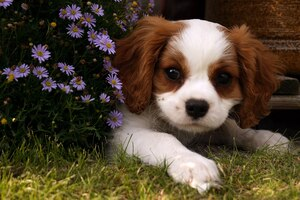

In [ ]:
fn = Path('./samples/puppy.jpg')
display.Image(filename=fn, width=200)

Now that we are passing more than just text, will need a helper function to upload media using Gemini's File API, which is the recomended way of passing media to the model.

In [ ]:
#| exports
def media_msg(fn: Path)->dict:
    if isinstance(fn, dict): return fn # Already processed
    f = genai.upload_file(fn)
    return {'file_data': {'mime_type': f.mime_type, 'file_uri': f.uri}}

Let's also update how we pass in text type messages, to be consistent

In [ ]:
#| exports
def text_msg(s:str)->dict:
    return {'text': s}

And finally lets add a helper function for make content correctly handles text and other media.

In [ ]:
#| exports
def _mk_content(src):
    "Create appropriate content data structure based on type of content"
    if isinstance(src,str): return text_msg(src)
    if isinstance(src,FunctionResponse): return src
    else: return media_msg(src)

Now let's make sure it properly handles text vs. Path objects for media

In [ ]:
_mk_content("Hi")

{'text': 'Hi'}

In [ ]:
_mk_content(fn)

{'file_data': {'mime_type': 'image/jpeg',
  'file_uri': 'https://generativelanguage.googleapis.com/v1beta/files/2aq3x67ccecn'}}

And now we need to update mk_msg to be able to handle multimedia messages correctly.

In [ ]:
#| exports
def mk_msg(content, role='user', **kw):
    if isinstance(content, GenerateContentResponse): role,content = 'model',contents(content)
    if isinstance(content, dict): role,content = content['role'],content['parts']
    if not isinstance(content, list): content=[content]
    if role == 'user': content = [_mk_content(o) for o in content] if content else ''
    return dict(role=role, parts=content, **kw)

In [ ]:
#| exports
def mk_msgs(msgs:list, **kw):
    "Helper to set 'assistant' role on alternate messages."
    if isinstance(msgs,str): msgs=[msgs]
    return [mk_msg(o, ('user','model')[i%2], **kw) for i,o in enumerate(msgs)]

In [ ]:
q = "In brief, what color flowers are in this image?"
mk_msgs([fn, q])

[{'role': 'user',
  'parts': [{'file_data': {'mime_type': 'image/jpeg',
     'file_uri': 'https://generativelanguage.googleapis.com/v1beta/files/3vaipajdqi7v'}}]},
 {'role': 'model',
  'parts': ['In brief, what color flowers are in this image?']}]

In [ ]:
mk_msgs(['Hi', 'Nice, to meet you. How can I help?', [fn, q]])

[{'role': 'user', 'parts': [{'text': 'Hi'}]},
 {'role': 'model', 'parts': ['Nice, to meet you. How can I help?']},
 {'role': 'user',
  'parts': [{'file_data': {'mime_type': 'image/jpeg',
     'file_uri': 'https://generativelanguage.googleapis.com/v1beta/files/l8zot30312js'}},
   {'text': 'In brief, what color flowers are in this image?'}]}]

Now, we should just be able to pass a list of multimedia content to our Chat client and it should be able to handle it all under the hood. Let's test it out.

In [ ]:
chat = Chat(model)

In [ ]:
chat([fn, q])

The flowers are purple. 

<details>

- content: {'parts': [{'text': 'The flowers are purple. \n'}], 'role': 'model'}
- finish_reason: 1
- index: 0
- safety_ratings: [{'category': 9, 'probability': 1, 'blocked': False}, {'category': 8, 'probability': 1, 'blocked': False}, {'category': 7, 'probability': 1, 'blocked': False}, {'category': 10, 'probability': 1, 'blocked': False}]
- token_count: 0
- grounding_attributions: []
- avg_logprobs: 0.0
- prompt_token_count: 270
- candidates_token_count: 5
- total_token_count: 275
- cached_content_token_count: 0

</details>

Hooray! That works, let's double check the history to make sure that everything is properly formatted and stored.

In [ ]:
mk_msgs(chat.h)

[{'role': 'user',
  'parts': [{'file_data': {'mime_type': 'image/jpeg',
     'file_uri': 'https://generativelanguage.googleapis.com/v1beta/files/5w5f40qezxsa'}},
   {'text': 'In brief, what color flowers are in this image?'}]},
 {'role': 'model', 'parts': ['The flowers are purple. \n']}]

While we are at it, let's update our markdown representation to handle the new messages.

In [ ]:
@patch
def _repr_markdown_(self:Chat):
    if not hasattr(self.c, 'result'): return 'No results yet'
    last_msg = contents(self.c.result)
    
    def fmt_part(ps):
        if len(ps) == 1: return fmt_single(ps[0])
        return '\n' + '\n'.join(f'- {fmt_single(p)}' for p in ps)
        
    def fmt_single(p):
        if 'text' in p: return p['text']
        if 'file_data' in p: return f"uploaded media: {p['file_data']['mime_type']}"
        return str(p)
        
    history = '\n\n'.join(f"**{m['role']}**: {fmt_part(m['parts'])}" 
                         for m in self.h if m['role'] in ('user','model'))
    det = self.c._repr_markdown_().split('\n\n')[-1]
    return f"""{last_msg}

<details>
<summary>History</summary>

{history}
</details>
{det}"""

In [ ]:
chat

The flowers are purple. 


<details>
<summary>History</summary>

**user**: 
- uploaded media: image/jpeg
- In brief, what color flowers are in this image?

**model**: The flowers are purple. 

</details>

| Metric | Count | Cost (USD) |
|--------|------:|-----:|
| Input tokens | 270 | 0.000020 |
| Output tokens | 5 | 0.000002 |
| Cache tokens | 0 | 0.000000 |
| **Total** | **275** | **$0.000022** |

## Other Media (audio, video, etc.)

Unlike ChatGPT and Claude, Gemini models can also handle audio and video inputs. Since we're using Gemini's File API for handling multimedia content, what we have should just work, except we'll need to make one small modification to the `media_msg` function. Also, while we are at it, let us also allow for users to pass in the bytes of the content instead of the path to be consistent with our other LLM provider libraries.

In [ ]:
#| exports 
def media_msg(
    media, # Media to process (Path|bytes|dict)
    mime=None # Optional mime type
)->dict: # Dict for Gemini API
    "Handle media input as either Path or bytes, returning dict for Gemini API"
    if isinstance(media, dict): return media # Already processed
    def _upload(f, mime=None):
        f = genai.upload_file(f, mime_type=mime)
        while f.state.name == "PROCESSING": time.sleep(2); f = genai.get_file(f.name)
        return {'file_data': {'mime_type': f.mime_type, 'file_uri': f.uri}}
    if isinstance(media, (str,Path)): return _upload(media)
    if isinstance(media, bytes) and mime is None: mime = ft.guess(media).mime
    return _upload(io.BytesIO(media if isinstance(media, bytes) else media.encode()), mime)

Since we're uploading potentially larger files, we need to wait for the upload and process to complete so that the media is ready to be consumed by the model.

In [ ]:
media_msg(fn), media_msg(fn.read_bytes())

({'file_data': {'mime_type': 'image/jpeg',
   'file_uri': 'https://generativelanguage.googleapis.com/v1beta/files/x9m2m0hp8it5'}},
 {'file_data': {'mime_type': 'image/jpeg',
   'file_uri': 'https://generativelanguage.googleapis.com/v1beta/files/zcekgao0ynim'}})

In [ ]:
chat = Chat(model)
img = fn.read_bytes()

In [ ]:
chat([img, q])

The flowers are purple. 

<details>

- content: {'parts': [{'text': 'The flowers are purple. \n'}], 'role': 'model'}
- finish_reason: 1
- index: 0
- safety_ratings: [{'category': 9, 'probability': 1, 'blocked': False}, {'category': 8, 'probability': 1, 'blocked': False}, {'category': 7, 'probability': 1, 'blocked': False}, {'category': 10, 'probability': 1, 'blocked': False}]
- token_count: 0
- grounding_attributions: []
- avg_logprobs: 0.0
- prompt_token_count: 270
- candidates_token_count: 5
- total_token_count: 275
- cached_content_token_count: 0

</details>

In [ ]:
# We'll test this with the example from Gemini's docs
video_fn = Path('./samples/selective_attention_test.mp4')
prompt = "Answer the question in the video"

In [ ]:
chat = Chat(model)
chat([video_fn, prompt])

The correct answer is 15. It's easy to get distracted by the gorilla, but you need to count the passes made by the players wearing white. 

<details>

- content: {'parts': [{'text': "The correct answer is 15. It's easy to get distracted by the gorilla, but you need to count the passes made by the players wearing white. \n"}], 'role': 'model'}
- finish_reason: 1
- index: 0
- safety_ratings: [{'category': 9, 'probability': 1, 'blocked': False}, {'category': 8, 'probability': 1, 'blocked': False}, {'category': 7, 'probability': 2, 'blocked': False}, {'category': 10, 'probability': 1, 'blocked': False}]
- token_count: 0
- grounding_attributions: []
- avg_logprobs: 0.0
- prompt_token_count: 10527
- candidates_token_count: 33
- total_token_count: 10560
- cached_content_token_count: 0

</details>

Takes a little while, but works like a charm! Now, let's try an audio file to make sure it also works.

In [ ]:
audio_fn = Path('./samples/attention_is_all_you_need.mp3')
audio = audio_fn.read_bytes()
prompt = "What is the audio about?"

In [ ]:
chat([audio, prompt])

The audio is a podcast discussion about the research paper "Attention is All You Need" by Vaswani et al. The paper introduces a new model architecture called the Transformer, which is based entirely on attention mechanisms and does away with recurrence and convolutions. The Transformer achieved significant improvements in performance and efficiency compared to previous models, especially in machine translation tasks. The podcast discusses the model's architecture, the benefits of attention mechanisms, the results of the experiments, and the future directions of research in this field. 

<details>

- content: {'parts': [{'text': 'The audio is a podcast discussion about the research paper "Attention is All You Need" by Vaswani et al. The paper introduces a new model architecture called the Transformer, which is based entirely on attention mechanisms and does away with recurrence and convolutions. The Transformer achieved significant improvements in performance and efficiency compared to previous models, especially in machine translation tasks. The podcast discusses the model\'s architecture, the benefits of attention mechanisms, the results of the experiments, and the future directions of research in this field. \n'}], 'role': 'model'}
- finish_reason: 1
- index: 0
- safety_ratings: [{'category': 9, 'probability': 1, 'blocked': False}, {'category': 8, 'probability': 1, 'blocked': False}, {'category': 7, 'probability': 1, 'blocked': False}, {'category': 10, 'probability': 1, 'blocked': False}]
- token_count: 0
- grounding_attributions: []
- avg_logprobs: 0.0
- prompt_token_count: 26361
- candidates_token_count: 101
- total_token_count: 26462
- cached_content_token_count: 0

</details>

Finally, let's check to make sure pdfs work as well.

In [ ]:
pdf_fn = Path('./samples/attention_is_all_you_need.pdf')
prompt = "What's mentioned in this pdf that's not mentioned in the previous podcast?"
chat([pdf_fn, prompt])

The PDF mentions the following details that were not in the previous podcast:

* **Specific details about the Transformer's architecture:** The PDF provides a more detailed description of the Transformer's architecture, including the number of layers, the dimensions of the embeddings and attention heads, and the use of positional encoding.
* **The use of label smoothing during training:** The PDF mentions the use of label smoothing, which is a technique that helps to improve the accuracy of the model by making it less confident in its predictions.
* **Results on English constituency parsing:** The PDF discusses the Transformer's performance on the English constituency parsing task, showing that it generalizes well to other tasks besides machine translation.
* **Examples of attention visualizations:** The PDF includes visualizations of the attention mechanisms used by the Transformer, highlighting how the model attends to different parts of the input sequence.

These details provide a more in-depth understanding of the Transformer's architecture, training process, and performance across different NLP tasks. 

<details>

- content: {'parts': [{'text': "The PDF mentions the following details that were not in the previous podcast:\n\n* **Specific details about the Transformer's architecture:** The PDF provides a more detailed description of the Transformer's architecture, including the number of layers, the dimensions of the embeddings and attention heads, and the use of positional encoding.\n* **The use of label smoothing during training:** The PDF mentions the use of label smoothing, which is a technique that helps to improve the accuracy of the model by making it less confident in its predictions.\n* **Results on English constituency parsing:** The PDF discusses the Transformer's performance on the English constituency parsing task, showing that it generalizes well to other tasks besides machine translation.\n* **Examples of attention visualizations:** The PDF includes visualizations of the attention mechanisms used by the Transformer, highlighting how the model attends to different parts of the input sequence.\n\nThese details provide a more in-depth understanding of the Transformer's architecture, training process, and performance across different NLP tasks. \n"}], 'role': 'model'}
- finish_reason: 1
- index: 0
- safety_ratings: [{'category': 9, 'probability': 1, 'blocked': False}, {'category': 8, 'probability': 1, 'blocked': False}, {'category': 7, 'probability': 1, 'blocked': False}, {'category': 10, 'probability': 1, 'blocked': False}]
- token_count: 0
- grounding_attributions: []
- avg_logprobs: 0.0
- prompt_token_count: 41393
- candidates_token_count: 202
- total_token_count: 41595
- cached_content_token_count: 0

</details>

Gemini does a pretty good job here!!

In [ ]:
pr = "Can you generate an exact transcript of the first minute or so of the podcast."
chat(pr)

Welcome to our podcast where we dive into groundbreaking research papers. Today we're discussing "Attention is all you need" by Vaswani et al. Joining us is an expert in machine learning. Welcome. Thanks for having me. I'm excited to discuss this revolutionary paper. Let's start with the core idea. What's the main thrust of this research? The paper introduces a new model architecture called the Transformer, which is based entirely on attention mechanisms. It completely does away with recurrence and convolutions, which were staples in previous sequence transduction models. 

<details>

- content: {'parts': [{'text': 'Welcome to our podcast where we dive into groundbreaking research papers. Today we\'re discussing "Attention is all you need" by Vaswani et al. Joining us is an expert in machine learning. Welcome. Thanks for having me. I\'m excited to discuss this revolutionary paper. Let\'s start with the core idea. What\'s the main thrust of this research? The paper introduces a new model architecture called the Transformer, which is based entirely on attention mechanisms. It completely does away with recurrence and convolutions, which were staples in previous sequence transduction models. \n'}], 'role': 'model'}
- finish_reason: 1
- index: 0
- safety_ratings: [{'category': 9, 'probability': 1, 'blocked': False}, {'category': 8, 'probability': 1, 'blocked': False}, {'category': 7, 'probability': 1, 'blocked': False}, {'category': 10, 'probability': 1, 'blocked': False}]
- token_count: 0
- grounding_attributions: []
- avg_logprobs: 0.0
- prompt_token_count: 41615
- candidates_token_count: 113
- total_token_count: 41728
- cached_content_token_count: 0

</details>

In [ ]:
chat

Welcome to our podcast where we dive into groundbreaking research papers. Today we're discussing "Attention is all you need" by Vaswani et al. Joining us is an expert in machine learning. Welcome. Thanks for having me. I'm excited to discuss this revolutionary paper. Let's start with the core idea. What's the main thrust of this research? The paper introduces a new model architecture called the Transformer, which is based entirely on attention mechanisms. It completely does away with recurrence and convolutions, which were staples in previous sequence transduction models. 


<details>
<summary>History</summary>

**user**: 
- uploaded media: video/mp4
- Answer the question in the video

**model**: The correct answer is 15. It's easy to get distracted by the gorilla, but you need to count the passes made by the players wearing white. 


**user**: 
- uploaded media: audio/mpeg
- What is the audio about?

**model**: The audio is a podcast discussion about the research paper "Attention is All You Need" by Vaswani et al. The paper introduces a new model architecture called the Transformer, which is based entirely on attention mechanisms and does away with recurrence and convolutions. The Transformer achieved significant improvements in performance and efficiency compared to previous models, especially in machine translation tasks. The podcast discusses the model's architecture, the benefits of attention mechanisms, the results of the experiments, and the future directions of research in this field. 


**user**: 
- uploaded media: audio/mpeg
- What is the audio about?

**model**: The audio is a podcast discussion about the research paper "Attention is All You Need" by Vaswani et al. The paper introduces a new model architecture called the Transformer, which is based entirely on attention mechanisms and does away with recurrence and convolutions. The Transformer achieved significant improvements in performance and efficiency compared to previous models, especially in machine translation tasks. The podcast discusses the model's architecture, the benefits of attention mechanisms, the results of the experiments, and the future directions of research in this field. 


**user**: 
- uploaded media: application/pdf
- What's mentioned in this pdf that's not mentioned in the previous podcast?

**model**: The PDF mentions the following details that were not in the previous podcast:

* **Specific details about the Transformer's architecture:** The PDF provides a more detailed description of the Transformer's architecture, including the number of layers, the dimensions of the embeddings and attention heads, and the use of positional encoding.
* **The use of label smoothing during training:** The PDF mentions the use of label smoothing, which is a technique that helps to improve the accuracy of the model by making it less confident in its predictions.
* **Results on English constituency parsing:** The PDF discusses the Transformer's performance on the English constituency parsing task, showing that it generalizes well to other tasks besides machine translation.
* **Examples of attention visualizations:** The PDF includes visualizations of the attention mechanisms used by the Transformer, highlighting how the model attends to different parts of the input sequence.

These details provide a more in-depth understanding of the Transformer's architecture, training process, and performance across different NLP tasks. 


**user**: Can you generate an exact transcript of the first minute or so of the podcast.

**model**: Welcome to our podcast where we dive into groundbreaking research papers. Today we're discussing "Attention is all you need" by Vaswani et al. Joining us is an expert in machine learning. Welcome. Thanks for having me. I'm excited to discuss this revolutionary paper. Let's start with the core idea. What's the main thrust of this research? The paper introduces a new model architecture called the Transformer, which is based entirely on attention mechanisms. It completely does away with recurrence and convolutions, which were staples in previous sequence transduction models. 

</details>

| Metric | Count | Cost (USD) |
|--------|------:|-----:|
| Input tokens | 138,306 | 0.020746 |
| Output tokens | 550 | 0.000330 |
| Cache tokens | 0 | 0.000000 |
| **Total** | **138,856** | **$0.021076** |

All of these also work with `Client` and can be combined with `structured` to get structured responses using multi-media data.

In [ ]:
class AudioMetadata(BasicRepr):
    """Class to hold metadata for audio files"""
    def __init__(
        self,
        n_speakers:int, # Number of speakers
        topic:str, # Topic discussed
        summary:str, # 100 word summary
        transcript:list[str], # Transcript of the audio segmented by speaker
    ): store_attr()
pr = "Extract the necessary information from the audio."

In [ ]:
c = Client(model)
audio_md = c.structured(mk_msgs([[audio_fn, pr]]), tools=[AudioMetadata])[0]

In [ ]:
print(f'Number of speakers: {audio_md.n_speakers}')
print(f'Topic: {audio_md.topic}')
print(f'Summary: {audio_md.summary}')
transcript = '\n-'.join(list(audio_md.transcript)[:10])
print(f'Transcript: {transcript}')

Number of speakers: 2.0
Topic: Attention is All You Need Paper Discussion
Summary: The paper introduces the Transformer model, which is based entirely on attention mechanisms. It eliminates recurrence and convolutions. The Transformer achieves state-of-the-art results in machine translation and other NLP tasks with significantly less training time. The paper discusses the model's architecture, attention mechanisms, and performance on various tasks. The Transformer is a significant advancement in the field of machine learning and NLP.
Transcript: 00:00 Welcome to our podcast where we dive into groundbreaking research papers.
-00:01 Today we’re discussing Attention is All You Need by Vaswani et al.
-00:02 Joining us is an expert in machine learning. Welcome.
-00:03 Thanks for having me. I’m excited to discuss this revolutionary paper.
-00:04 Let’s start with the core idea. What’s the main thrust of this research?
-00:05 The paper introduces a new model architecture called the Transformer

## Export -

In [ ]:
#|hide
#|eval: false
from nbdev.doclinks import nbdev_export
nbdev_export()